In [117]:
import time
import itertools
import dateutil
import pickle
import datetime
import locale
import hashlib
import pycountry
import pandas as pd
import numpy as np
import scipy
from scipy.spatial import distance as ssd
from sklearn import model_selection, preprocessing, metrics
from collections import defaultdict


In [11]:
df_train = pd.read_csv('/Users/JQC/Desktop/data/train.csv')
df_test = pd.read_csv('/Users/JQC/Desktop/data/test.csv')

df_train.shape, df_test.shape

((15398, 6), (10237, 4))

In [12]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

df_train.shape, df_test.shape

((15398, 6), (10237, 4))

In [13]:
df_train.head()

,user,event,invited,timestamp,interested,not_interested
0,3044012,1918771225,0,2012-10-02 15:53:05.754000+00:00,0,0
1,3044012,1502284248,0,2012-10-02 15:53:05.754000+00:00,0,0
2,3044012,2529072432,0,2012-10-02 15:53:05.754000+00:00,1,0
3,3044012,3072478280,0,2012-10-02 15:53:05.754000+00:00,0,0
4,3044012,1390707377,0,2012-10-02 15:53:05.754000+00:00,0,0


In [14]:
df_test.head()

,user,event,invited,timestamp
0,1776192,2877501688,0,2012-11-30 11:39:01.230000+00:00
1,1776192,3025444328,0,2012-11-30 11:39:01.230000+00:00
2,1776192,4078218285,0,2012-11-30 11:39:01.230000+00:00
3,1776192,1024025121,0,2012-11-30 11:39:01.230000+00:00
4,1776192,2972428928,0,2012-11-30 11:39:21.985000+00:00


In [15]:
# 没有缺失值
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15398 entries, 0 to 15397
Data columns (total 6 columns):
user              15398 non-null int64
event             15398 non-null int64
invited           15398 non-null int64
timestamp         15398 non-null object
interested        15398 non-null int64
not_interested    15398 non-null int64
dtypes: int64(5), object(1)
memory usage: 842.1+ KB


In [16]:
# 没有缺失值
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10237 entries, 0 to 10236
Data columns (total 4 columns):
user         10237 non-null int64
event        10237 non-null int64
invited      10237 non-null int64
timestamp    10237 non-null object
dtypes: int64(3), object(1)
memory usage: 399.9+ KB


## 处理user和event关联数据

In [17]:
# 获取训练集合测试集中所有不重复的用户
unique_users = set(df_train.user) | set(df_test.user)
# 元祖推导式 在把众多元祖转化为字典 dict((422002690, 0), (2678956041, 1),...)
user_index_dic = dict(((user, index) for index, user in enumerate(unique_users)))

# 取出所有不重复的事件
unique_events = set(df_train.event) | set(df_test.event)
event_index_dic = dict(((event, index) for index, event in enumerate(unique_events)))

# 建立user~event的稀疏矩阵
user_event_scores = scipy.sparse.dok_matrix((len(unique_users), len(unique_events)))

# 将训练集中的user~event 对应到user_event_scores中 score为interested - not_interested
for line in df_train.itertuples():
    user_index = user_index_dic[line[1]]
    event_index = event_index_dic[line[2]]
    user_event_scores[user_index, event_index] = line[5] - line[6]


scipy.io.mmwrite("PE_userEventScores", user_event_scores)
pickle.dump(user_index_dic, open("PE_userIndex.pkl", 'wb'))
pickle.dump(event_index_dic, open("PE_eventIndex.pkl", 'wb'))

## 用户与用户相似度矩阵

In [151]:
df_users = pd.read_csv('/Users/JQC/Desktop/data/users.csv', 
#                        dtype = {'column_name' : int, 'timezone': int}
                      )

df_users.head()

,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,3197468391,id_ID,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,480.0
1,3537982273,id_ID,1992,male,2012-09-29T18:03:12.111Z,Medan Indonesia,420.0
2,823183725,en_US,1975,male,2012-10-06T03:14:07.149Z,Stratford Ontario,-240.0
3,1872223848,en_US,1991,female,2012-11-04T08:59:43.783Z,Tehran Iran,210.0
4,3429017717,id_ID,1995,female,2012-09-10T16:06:53.132Z,NaN,420.0


In [4]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 7 columns):
user_id      38209 non-null int64
locale       38209 non-null object
birthyear    38209 non-null object
gender       38100 non-null object
joinedAt     38152 non-null object
location     32745 non-null object
timezone     37773 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.0+ MB


In [147]:
# 将国家转化为对应的索引
countryIdMap = defaultdict(int)
ctryIdx = defaultdict(int)
for index, country in enumerate(pycountry.countries):
    countryIdMap[country.name.lower()] = index + 1
    if country.name.lower() == "usa":
        ctryIdx["US"] = index
    if country.name.lower() == "canada":
        ctryIdx["CA"] = index
        
for cc in ctryIdx.keys():
    # 获取美国 加拿大的省份
  for s in pycountry.subdivisions.get(country_code=cc):
    countryIdMap[s.name.lower()] = ctryIdx[cc] + 1

In [150]:
# 辅助函数
# 日期处理函数
def join_time_to_YM(join_time):
    if join_time.lower() == 'none':
        return 0
    dttm = datetime.datetime.strptime(str(join_time), "%Y-%m-%dT%H:%M:%S.%fZ")
    return "".join([str(dttm.year), str(dttm.month)])



def getCountryId(location):
    if (isinstance(location, str)
        and len(location.strip()) > 0
        and location.rfind("  ") > -1):
      return countryIdMap[location[location.rindex("  ") + 2:].lower()]
    else:
      return 0
join_time_to_YM(df_users.loc[0, 'joinedAt'])


'201210'

In [152]:
# birthyear 处理特殊值 23-May 16-Mar
df_users.loc[df_users.birthyear == '23-May', 'birthyear'] = '1923'
df_users.loc[df_users.birthyear == '16-Mar', 'birthyear'] = '1916'
df_users.loc[df_users.birthyear == 'None', 'birthyear'] = '0'

# timezone处理缺失值
df_users.timezone.fillna(0, inplace=True)

# 将birthyear timezone 转化为整型
df_users.birthyear = df_users.birthyear.apply(lambda x: int(x))
df_users.timezone = df_users.timezone.apply(lambda x: int(x))

# gender 用众数去填充
df_users.gender.fillna('male', inplace=True)
df_users.gender = df_users.gender.map({'male': 1, 'female': 0})

# joinedAt 日期转化为201210
df_users.joinedAt = df_users.loc[df_users.joinedAt.notna(), 'joinedAt'].apply(lambda x: join_time_to_YM(x)).astype(int)
# joinedAt 缺失值填充0
# df_users.loc[df_users.joinedAt.isna(), 'joinedAt'] = 0

# 处理locale 将locale转化为对应的索引
# locale.locale_alias.keys() --> ['zh_cn', uk, ....] 各个地方的语言
df_users.locale = df_users.locale.apply(lambda x: list(locale.locale_alias.keys()).index('id_ID'.lower()))
df_users.location = df_users.location.apply(lambda x: getCountryId(x))

# 
user_matrix = scipy.sparse.dok_matrix((len(unique_users), len(df_users.columns) - 1))
for u_id in df_users.user_id:
    if not u_id in user_index_dic:
        continue
    user_index = user_index_dic[u_id]
    user_matrix[user_index] = df_users.loc[df_users.user_id == u_id, df_users.columns[df_users.columns != 'user_id']]
user_matrix = preprocessing.normalize(user_matrix, norm='l1', axis=0)
scipy.io.mmwrite('US_userMatrix', user_matrix)

# 计算用户的相似度 并保存到本地
userSimMatrix = metrics.pairwise.cosine_similarity(user_matrix)
scipy.io.mmwrite("US_userSimMatrix", userSimMatrix)

## 用户社交关系挖掘

In [133]:
df_friends = pd.read_csv('/Users/JQC/Desktop/data/user_friends.csv')
df_friends.head()

,user,friends
0,3197468391,1346449342 3873244116 4226080662 1222907620 54...
1,3537982273,1491560444 395798035 2036380346 899375619 3534...
2,823183725,1484954627 1950387873 1652977611 4185960823 42...
3,1872223848,83361640 723814682 557944478 1724049724 253059...
4,3429017717,4253303705 2130310957 1838389374 3928735761 71...


In [135]:
df_friends['friend_count'] = df_friends.loc[df_friends.friends.notna(), 'friends'].apply(lambda x: len(x.split(' ')))
df_friends.loc[df_friends.friends.isna(), 'friend_count'] = 0
df_friends.head()

,user,friends,friend_count
0,3197468391,1346449342 3873244116 4226080662 1222907620 54...,3623.0
1,3537982273,1491560444 395798035 2036380346 899375619 3534...,1467.0
2,823183725,1484954627 1950387873 1652977611 4185960823 42...,96.0
3,1872223848,83361640 723814682 557944478 1724049724 253059...,13.0
4,3429017717,4253303705 2130310957 1838389374 3928735761 71...,1136.0


In [131]:
start_time = time.time()
user_friends = scipy.sparse.dok_matrix((len(unique_users), len(unique_users)))
# 将friends为空的地方全填 0
df_friends[df_friends.friends.isna()] = 0
# for user in df_friends[df_friends.friends.notna()].user:
for user in df_friends.user:
    # 查看当前用户是否在user_index_dic 实际上是查看当前用户是否存在于训练集和测试集
    if user in user_index_dic:
        # 取出当前用户对应的索引
        cur_user_index = user_index_dic[user] 
        if type(df_friends.loc[df_friends.user==user, 'friends']) == type(0):
            user_friends[cur_user_index] = 0
            continue
        # 接下来就要遍历当前用户中所有的朋友,查看他朋友对参加event的积极性
        for friend in df_friends.loc[df_friends.user==user, 'friends'].str.split(' ').tolist()[0]:
            # 判断当前用户的朋友是否存在于训练集和测试集中
            # 因为当初user_index_dic中的key为int类型的 现在也要转化一下
            friend = int(friend)
            if friend in user_index_dic:
                user_index = user_index_dic[friend]
                event_for_user = user_event_scores[user_index]
                # 查看朋友对事件的积极度 朋友感兴趣的所有事件/ 所有事件
                score = np.sum(event_for_user) / user_event_scores.shape[1]
                user_friends[cur_user_index, user_index] += score

# l1范式归一化
user_friends = preprocessing.normalize(user_friends, norm="l1", axis=0, copy=False)
scipy.io.mmwrite("UF_userFriends", user_friends)

num_friends = np.zeros(len(unique_users))
for user in df_friends.user:
    if user in user_index_dic:
        user_index = user_index_dic[user]
        num_friends[user_index] = df_friends.loc[df_friends.user == user, 'friend_count']

# 归一化数组
num_friends = (num_friends - num_friends.min()) / (num_friends.max() - num_friends.min())
scipy.io.mmwrite('UF_numFriends', np.mat(num_friends))

end_time = time.time()
print('运行时间:%s min' % str((end_time - start_time) / 60))

运行时间:0.3067625800768534 min


## 5.构造event和event相似度数据

In [156]:
start_time = time.time()

def getFeatureHash(value):
    if len(value.strip()) == 0:
      return -1
    elif value.lower() == 'none':
        return 0
    else:
      return int(hashlib.sha224(value.encode('utf8')).hexdigest()[0:4], 16)

# events 这个文件太大了 (1.17g) 不想电脑被卡死就采取读取文件方式
with open('/Users/JQC/Desktop/data/events.csv', 'r') as f:
    f.readline().strip().split(',')
    nevents = len(event_index_dic.keys())
    eventPropMatrix = scipy.sparse.dok_matrix((nevents, 7))
    eventContMatrix = scipy.sparse.dok_matrix((nevents, 100))
    for line in f:
        cols = line.strip().split(",")
        eventId = int(cols[0])
        if eventId in event_index_dic:
            i = event_index_dic[eventId]
            eventPropMatrix[i, 0] = join_time_to_YM(cols[2]) # start_time
            eventPropMatrix[i, 1] = getFeatureHash(cols[3]) # city
            eventPropMatrix[i, 2] = getFeatureHash(cols[4]) # state
            eventPropMatrix[i, 3] = getFeatureHash(cols[5]) # zip
            eventPropMatrix[i, 4] = getFeatureHash(cols[6]) # country .encode('utf8')
            eventPropMatrix[i, 5] = 0 if len(cols[7].strip()) == 0 else float(cols[7]) # lat
            eventPropMatrix[i, 6] = 0 if len(cols[8].strip()) == 0 else float(cols[8]) # lon
            # 第9列开始是c_1, c_2....c_100
            for j in range(9, 109):
              eventContMatrix[i, j-9] = cols[j]
            
end_time = time.time()
print('运行时间:%s min' % str((end_time - start_time) / 60))

运行时间:2.8156172037124634 min


In [157]:
eventPropMatrix[:, 0]

<13418x1 sparse matrix of type '<class 'numpy.float64'>'
	with 13418 stored elements in Dictionary Of Keys format>

In [159]:
# l1范式 归一化
eventPropMatrix = preprocessing.normalize(eventPropMatrix,
    norm="l1", axis=0, copy=False)
eventContMatrix = preprocessing.normalize(eventContMatrix,
    norm="l1", axis=0, copy=False)

# 写入本地
scipy.io.mmwrite("EV_eventPropMatrix", eventPropMatrix)
scipy.io.mmwrite("EV_eventContMatrix", eventContMatrix)

In [163]:
start_time = time.time()

# 计算事件之间的相似度
eventPropSim = metrics.pairwise.cosine_similarity(eventPropMatrix)
eventContSim = metrics.pairwise.cosine_similarity(eventContMatrix)

# 写入本地
scipy.io.mmwrite("EV_eventPropSim", eventPropSim)
scipy.io.mmwrite("EV_eventContSim", eventContSim)


end_time = time.time()
print('运行时间:%s min' % str((end_time - start_time) / 60))

运行时间:10.01778351465861 min


In [164]:
eventPropSim

array([[1.        , 0.99999755, 0.36096396, ..., 0.52486899, 0.5658294 ,
        0.99999755],
       [0.99999755, 1.        , 0.36136045, ..., 0.52487027, 0.56583079,
        1.        ],
       [0.36096396, 0.36136045, 1.        , ..., 0.50146408, 0.4291896 ,
        0.36136044],
       ...,
       [0.52486899, 0.52487027, 0.50146408, ..., 1.        , 0.9676884 ,
        0.52487027],
       [0.5658294 , 0.56583079, 0.4291896 , ..., 0.9676884 , 1.        ,
        0.56583079],
       [0.99999755, 1.        , 0.36136044, ..., 0.52487027, 0.56583079,
        1.        ]])

## 6.活跃度/event热度 数据

In [165]:
df_event_attendees = pd.read_csv('/Users/JQC/Desktop/data/event_attendees.csv')
df_event_attendees.head()

,event,yes,maybe,invited,no
0,1159822043,1975964455 252302513 4226086795 3805886383 142...,2733420590 517546982 1350834692 532087573 5831...,1723091036 3795873583 4109144917 3560622906 31...,3575574655 1077296663
1,686467261,2394228942 2686116898 1056558062 3792942231 41...,1498184352 645689144 3770076778 331335845 4239...,1788073374 733302094 1830571649 676508092 7081...,NaN
2,1186208412,NaN,3320380166 3810793697,1379121209 440668682,1728988561 2950720854
3,2621578336,NaN,NaN,NaN,NaN
4,855842686,2406118796 3550897984 294255260 1125817077 109...,2671721559 1761448345 2356975806 2666669465 10...,1518670705 880919237 2326414227 2673818347 332...,3500235232


In [251]:
start_time = time.time()

eventPopularity = scipy.sparse.dok_matrix((len(unique_events), 1))
for event in df_event_attendees.event[(df_event_attendees.yes.notna()) & (df_event_attendees.no.notna())]:
    if event in event_index_dic:
        # pd.isna(df_event_attendees.loc[df_event_attendees.event == event, 'yes']).values[0]
        event_index = event_index_dic[event]
        eventPopularity[event_index, 0] = len(df_event_attendees.loc[df_event_attendees.event == event, 'yes'].values[0].split(' ')[0]) - \
        len(df_event_attendees.loc[df_event_attendees.event == event, 'no'].values[0].split(' ')[0])

eventPopularity = preprocessing.normalize(eventPopularity, norm='l1',  axis=0, copy=False)
scipy.io.mmwrite('EA_eventPopularity', eventPopularity)

end_time = time.time()
print('运行时间:%s min' % str((end_time - start_time) / 60))

运行时间:0.15210508505503337 min


In [252]:
eventPopularity

<13418x1 sparse matrix of type '<class 'numpy.float64'>'
	with 3622 stored elements in Compressed Sparse Column format>

## 8.构建特征

In [390]:
def userReco(userId, eventId):
    """
    根据User-based协同过滤，得到event的推荐度
    基本的伪代码思路如下：
    """
    # event推荐度
    i = user_index_dic[userId]
    j = event_index_dic[eventId]
    # 拿到用户之间的相似度 再拿到j事件下所有的得分
    vs = user_event_scores[:, j]
    sims = userSimMatrix[i, :]
    # 向量相乘当前用户对该事件的推荐度
    prod = sims * vs
    return prod[0] - user_event_scores[i, j]


def eventReco(userId, eventId):
    """
    根据基于物品的协同过滤，得到Event的推荐度
    基本的伪代码思路如下：
    """
    i = user_index_dic[userId]
    j = event_index_dic[eventId]
    js = user_event_scores[i, :]
    psim = eventPropSim[:, j]
    csim = eventContSim[:, j]
    # 拿到事件的相似度乘以 事件的score 得到事件的推荐度
    pprod = js * psim
    cprod = js * csim
    pscore = pprod[0] - user_event_scores[i, j]
    cscore = cprod[0] - user_event_scores[i, j]

    return pscore, cscore

def userPop(userId):
    """
    基于用户的朋友个数来推断用户的社交程度
    主要的考量是如果用户的朋友非常多，可能会更倾向于参加各种社交活动
    """
    if userId in user_index_dic:
        i = user_index_dic[userId]
        # 该用户有多少朋友
        return num_friends[i]
    else:
        return 0

def friendInfluence(userId):
    """
    朋友对用户的影响
    主要考虑用户所有的朋友中，有多少是非常喜欢参加各种社交活动/event的
    用户的朋友圈如果都积极参与各种event，可能会对当前用户有一定的影响
    """
    nusers = np.shape(user_friends)[1]
    i = user_index_dic[userId]
    # 该用户的朋友积极参加活动的程度
#     return (user_friends[i, :].sum(axis=0) / nusers)[0,0]
    return user_friends[i].sum()

def eventPop(eventId):
    """
    本活动本身的热度
    主要是通过参与的人数来界定的
    """
    i = event_index_dic[eventId]
    return eventPopularity[i, 0]

In [264]:
data_train = pd.DataFrame(columns=['userId', 'eventId', "invited", "user_reco", "evt_p_reco",
        "evt_c_reco", "user_pop", "frnd_infl", "evt_pop", 'interested', 'not_interested'])

In [384]:
data_train.userId = df_train.user
data_train.eventId = df_train.event
data_train.invited = df_train.invited
data_train.interested = df_train.interested
data_train.not_interested = df_train.not_interested

In [386]:
start_time = time.time()

for index, line in enumerate(data_train.itertuples()):
    userId = int(line[1])
    eventId = int(line[2])
    i = user_index_dic[userId]
    j = event_index_dic[eventId]
    evt_p_reco, evt_c_reco = eventReco(userId, eventId)
    
    data_train.loc[index, 'user_reco'] = userReco(userId, eventId)
    data_train.loc[index, 'evt_p_reco'] = evt_p_reco    
    data_train.loc[index, 'evt_c_reco'] = evt_c_reco
    
    data_train.loc[index, 'user_pop'] = userPop(userId)
    data_train.loc[index, 'frnd_infl'] = friendInfluence(userId)
    data_train.loc[index, 'evt_pop'] = eventPop(eventId)

end_time = time.time()
print('运行时间:%s min' % str((end_time - start_time) / 60))

运行时间:4.286600251992543 min


In [387]:
data_train.head()

,userId,eventId,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop,interested,not_interested
0,3044012,1918771225,0,0.000000,0.290735,0,0.175499,0,-0.000245942,0,0
1,3044012,1502284248,0,0.000000,0.907079,0.447731,0.175499,0,0,0,0
2,3044012,2529072432,0,65.239331,0,0,0.175499,0,-0.000245942,1,0
3,3044012,3072478280,0,0.000000,0.381639,0.186315,0.175499,0,0,0,0
4,3044012,1390707377,0,13.993137,1,0.0208354,0.175499,0,0.000245942,0,0


In [436]:
data_test = pd.DataFrame(columns=['userId', 'eventId', "invited", "user_reco", "evt_p_reco",
        "evt_c_reco", "user_pop", "frnd_infl", "evt_pop"])
data_test.userId = df_test.user
data_test.eventId = df_test.event
data_test.invited = df_test.invited

data_test.head()

,userId,eventId,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop
0,1776192,2877501688,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1776192,3025444328,0,NaN,NaN,NaN,NaN,NaN,NaN
2,1776192,4078218285,0,NaN,NaN,NaN,NaN,NaN,NaN
3,1776192,1024025121,0,NaN,NaN,NaN,NaN,NaN,NaN
4,1776192,2972428928,0,NaN,NaN,NaN,NaN,NaN,NaN


In [438]:
start_time = time.time()

for index, line in enumerate(data_test.itertuples()):
    userId = int(line[1])
    eventId = int(line[2])
    i = user_index_dic[userId]
    j = event_index_dic[eventId]
    evt_p_reco, evt_c_reco = eventReco(userId, eventId)
    
    data_test.loc[index, 'user_reco'] = userReco(userId, eventId)
    data_test.loc[index, 'evt_p_reco'] = evt_p_reco    
    data_test.loc[index, 'evt_c_reco'] = evt_c_reco
    
    data_test.loc[index, 'user_pop'] = userPop(userId)
    data_test.loc[index, 'frnd_infl'] = friendInfluence(userId)
    data_test.loc[index, 'evt_pop'] = eventPop(eventId)

end_time = time.time()
print('运行时间:%s min' % str((end_time - start_time) / 60))

运行时间:2.6350266496340433 min


In [441]:
data_test.head()

,userId,eventId,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop
0,1776192,2877501688,0,0,0,0,0.0896861,0,0
1,1776192,3025444328,0,0,0,0,0.0896861,0,0.000245942
2,1776192,4078218285,0,0,0,0,0.0896861,0,0
3,1776192,1024025121,0,0,0,0,0.0896861,0,0
4,1776192,2972428928,0,0,0,0,0.0896861,0,0


In [448]:
# 生成的训练数据和测试数据保存到本地
data_train.to_csv('data_train.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

## 建模与预测


In [478]:
# 终于到了建模 哈哈....

import numpy as np
import pandas as pd
from sklearn import metrics, model_selection, linear_model, naive_bayes, preprocessing
from matplotlib import pyplot as plt
import scikitplot as skplt


In [450]:
train_df = pd.read_csv('data_train.csv')

In [451]:
train_df.head()

,userId,eventId,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop,interested,not_interested
0,3044012,1918771225,0,0.000000,0.290735,0.000000,0.175499,0.0,-0.000246,0,0
1,3044012,1502284248,0,0.000000,0.907079,0.447731,0.175499,0.0,0.000000,0,0
2,3044012,2529072432,0,65.239331,0.000000,0.000000,0.175499,0.0,-0.000246,1,0
3,3044012,3072478280,0,0.000000,0.381639,0.186315,0.175499,0.0,0.000000,0,0
4,3044012,1390707377,0,13.993137,1.000000,0.020835,0.175499,0.0,0.000246,0,0


In [452]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15398 entries, 0 to 15397
Data columns (total 11 columns):
userId            15398 non-null int64
eventId           15398 non-null int64
invited           15398 non-null int64
user_reco         15398 non-null float64
evt_p_reco        15398 non-null float64
evt_c_reco        15398 non-null float64
user_pop          15398 non-null float64
frnd_infl         15398 non-null float64
evt_pop           15398 non-null float64
interested        15398 non-null int64
not_interested    15398 non-null int64
dtypes: float64(6), int64(5)
memory usage: 1.3 MB


In [453]:
train_df.shape

(15398, 11)

In [454]:
train_df.invited.value_counts()

0    14744
1      654
Name: invited, dtype: int64

In [455]:
# 样本不均衡
train_df.invited.value_counts()[0] / train_df.invited.value_counts()[1] 

22.54434250764526

In [462]:
# 因为补集朴素贝叶斯对样本不均衡问题有很好的效果而且运行速度很快 所以我优先考虑使用补集朴素贝叶斯进行尝试
# 补集朴素贝叶斯的特点就是 数据中不能有负数
train_df_data = train_df.copy()
train_df_data.iloc[:, 3:9] = preprocessing.MinMaxScaler().fit_transform(train_df_data.iloc[:, 3:9])
# 划分训练集和测试集

# X = train_df_data.loc[:, train_df.columns[train_df.columns != 'invited']]
X = train_df_data.iloc[:, 3:]

y = train_df_data.iloc[:, 2]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=66)


In [463]:
X_train.head()

,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop,interested,not_interested
10305,0.096724,0.652174,0.540641,0.306971,0.210184,0.625,0,0
7896,0.018372,0.648632,0.537982,0.180595,0.130011,0.500,0,0
12265,0.009186,0.744315,0.582555,0.262332,0.130011,0.500,0,0
2296,0.009186,0.670988,0.537263,0.227069,0.238353,0.500,0,0
9396,0.009186,0.669520,0.540849,0.049124,0.130011,0.500,0,0


In [464]:
# 因为补集朴素贝叶斯对样本不均衡问题有很好的效果而且运行速度很快 所以我优先考虑使用补集朴素贝叶斯
# 补集朴素贝叶斯的特点就是 数据中不能有负数
clf = naive_bayes.ComplementNB()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

0.3548895899053628


In [465]:
# 查看模型的评估指标
metrics.confusion_matrix(y_train, clf.predict(X_train))

array([[3462, 6853],
       [ 100,  363]])

In [431]:
metrics.recall_score(y_train, clf.predict(X_train)), metrics.accuracy_score(y_train, clf.predict(X_train))

(0.7840172786177105, 0.3548895899053628)

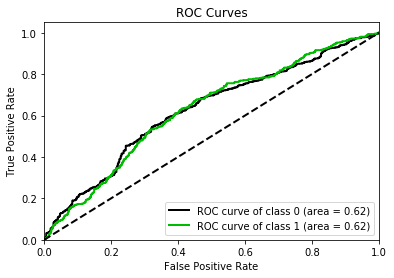

In [432]:
# 虽然recall_score 还可以 但是auc不太好 因为这个模型没有什么可调的参数 只能换模型尝试
test_proba_df = pd.DataFrame(clf.predict_proba(X_train))
skplt.metrics.plot_roc(y_train, test_proba_df, plot_micro=False, plot_macro=False)

In [473]:
# 换SGDClassifier试一试
clf = linear_model.SGDClassifier(max_iter=1000, 
                                 loss="log", 
                                 penalty="l2", 
#                                  class_weight='balanced'
                                ).fit(train_df.iloc[:, 3:], train_df.iloc[:, 2])
clf.score(train_df.iloc[:, 3:], train_df.iloc[:, 2])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  return sample_weight


0.9575269515521496

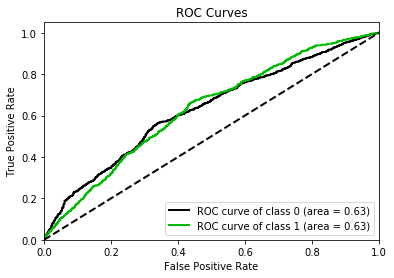

In [474]:
test_proba_df = pd.DataFrame(clf.predict_proba(train_df.iloc[:, 3:]))
skplt.metrics.plot_roc(train_df.iloc[:, 2], test_proba_df, plot_micro=False, plot_macro=False)